<img src="./images/icos.png" />

# A little demonstrator to access the LimeSurvey service.
At the ICOS Carbon Portal, we host the limesurvey software (http://www.limesurvey.org) to provide a tool for  gathering
information about ICOS as European Reaearch Infrastructure and the corresponding services provided.

### To 'declutter' the notebook we have hidden all the code. You can run the notebook and below each explanation you will find the 'output' for the cod snippets.


If you are curious how it's done, you can click the button below to see and change the code...

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## load modules

A list of python modules and custom libraries 

In [2]:
import os
import sys
import base64
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import shutil

# custom libraries
sys.path.append(os.getcwd())
print("add current directory to the path, to load the icos scripts")
import icoslimer
import report

add current directory to the path, to load the icos scripts



## set credentials and connect to the survey server


In [3]:
url = 'http://localhost/limesurvey/index.php/admin/remotecontrol'
usr = 'limey'
pwd = 'EnvriPlus'

lime = icoslimer.IcosLimer()
lime.set_url(url)
lime.set_auth(usr, pwd)
lime.set_session_key()

if type(lime.session_key) is str:
    print("A session key was generated: " + lime.session_key)
else:
    print("soemthing is wrong: " + lime.session_key)


A session key was generated: umxd7g17_uX9BSMZmCV33J5t3EDeGiMX


## get all surveys

In [4]:
surveys = lime.list_surveys()

for s in surveys['result']:
    print(s)

{'sid': '312777', 'surveyls_title': 'testi', 'startdate': None, 'expires': '2019-04-03 03:19:21', 'active': 'N'}
{'sid': '341979', 'surveyls_title': 'staticpdf', 'startdate': None, 'expires': None, 'active': 'Y'}
{'sid': '424932', 'surveyls_title': 'just add add survey to add another timeline....', 'startdate': None, 'expires': None, 'active': 'Y'}


## extract the statistics for the surveys and store them in a list

### define the options for the output
@ output_format (string): choose between **html, xls, pdf**. Default is set to '**html**'.<br>
@ lang (string):  you can choose a specific language, provide empty string for survey default language.<br>
@ graph (string) [0|1]: set graph to "1" if you like to have bar charts included. This works only with pdf.<br>
<br>
If statistics are available for a survey, add to list. The output is a variable "stats_list".

In [5]:

w = widgets.Dropdown(
    options=['html', 'xls', 'pdf'],
    output_format='html',
    description='output:',
    disabled=False,
)
display(w)


Dropdown(description='output:', options=('html', 'xls', 'pdf'), value='html')

In [6]:
w.value

'html'

In [7]:


output_format = w.value
lang = ''
graph = '0'

stats_list = []

for s in surveys['result']:

    stats = lime.get_statistics(s['sid'], output_format)

    # check if it is a json object and decode base64
    try:        
        stats = base64.b64decode(stats['result'])          
        stats_list.append([s['sid'], stats])
        print('add stats for ' + s['sid'])
    except:
        print('------->')
        print('error processing survey ' + s['sid'])
        print(stats['error'])
        print('<-------')
        
        pass
        
        
if len(stats_list) > 0:
    print(str(len(stats_list)) + ' stats available')


------->
error processing survey 312777
CDbCommand failed to execute the SQL statement: SQLSTATE[42S02]: Base table or view not found: 1146 Table 'envriplus.lime_survey_312777' doesn't exist
<-------
add stats for 341979
add stats for 424932
2 stats available


## You can get a timeline for each survery. 

<br>
@ startdate(string): yyyymmdd<br>
@ enddate(string): yyyymmdd
<br>
@ output: timeline_list one entry for each survey with counts per day


In [8]:
startdate = '20190101'
enddate = '20251231'


timeline_list = []  
for s in stats_list:
    t = lime.get_timeline(s[0], 'day', startdate, enddate)
    timeline_list.append([s[0], t['result']])
    print('timeline added for survey: ' + s[0])
    

timeline added for survey: 341979
timeline added for survey: 424932


### Release the session key to the limesurvey server. We have all the information we want stored in:

- **surveys**
- **stats_list**
- **timeline_list**

In [9]:
lime.release_session_key()

### Store the statistics provided from limesurvey as file.
The output is a file for each survey in the format of surveyid.output_format, ***./out/surveyid.output_format***


In [10]:
# make sure the output directories are available
if not os.path.isdir('out'):
    os.mkdir('out')
    
print('output format is set to: ' + output_format)
for index, stats in stats_list:
    if not os.path.isdir('./out/'+index):
        os.mkdir('./out/' + index)
        
    filename = './out/' + index + '/' +index + '.' + output_format        
    with open(filename, 'wb') as f:
        f.write(stats)
    
    lnk = 'stats for ' + index + ' saved to: <a href="' + filename + '" target="_blank">' + filename +'</a>'
    display(HTML(lnk))
    

output format is set to: html


### If output_format is  "html",  display the html file



In [11]:
if output_format == 'html' and len(stats_list) > 0:
    print('As an example we display only the first file')
    f = './out/' +stats_list[0][0] + '/' + stats_list[0][0] + '.' + output_format
    display(HTML(filename=f))
else:
    print('nothing to do')

 
    

As an example we display only the first file


### If output_format is  "xls",  read the data into a pandas data frame to calculate your own statistics

In [12]:
if output_format == 'xls':
    for id, s in stats_list:
        dataframe = pd.read_excel(io.BytesIO(s))        
        display(dataframe)
else:
    print('nothing to do')

nothing to do


 ### We have extracted the timelines for each survey, we can display the table or plot a graph
- display the "raw" table
- extract the values for each survey 

In [13]:
# display a panda dataframe
col = ['sid', 'count']
df = pd.DataFrame(timeline_list, columns=col)
print('raw table')
display(df)

raw table


,sid,count
0,341979,"{'2019-04-03': 7, '2019-04-04': 3, '2019-04-05..."
1,424932,"{'2019-04-24': 4, '2019-04-26': 5}"


In [14]:
# extract the values for each survey 
print('values extracted for each survey')
for t in timeline_list:
    val = []
    sid = t[0]
    data = t[1]
    for k,v in data.items():
        val.append([sid,k,v])
    
    df = pd.DataFrame(val, columns=['sid', 'time', 'count'])
    display(df)

values extracted for each survey


,sid,time,count
0,341979,2019-04-03,7
1,341979,2019-04-04,3
2,341979,2019-04-05,4


,sid,time,count
0,424932,2019-04-24,4
1,424932,2019-04-26,5


### use matplotlib to create a combined lineplot and markers for all surveys

(0, 7.2)

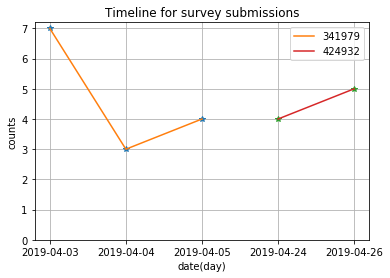

In [15]:


fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date(day)', ylabel='counts',
       title='Timeline for survey submissions')

for t in timeline_list:
    ts=[]
    count=[]
    sid = t[0]
    data = t[1]
    for k,v in data.items():        
        ts.append(v)
        count.append(k)
    ax.plot(count, ts, '*')
    ax.plot(count, ts, label=sid)

ax.legend()
ax.set_ylim(bottom=0)

### use the same plot, but instead save figures individually for each survey
<br>
for the moment the output is hardcoded to the folder ./out/surveyid


In [16]:
print('processing timelines..')
for t in timeline_list:
    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='date (day)', ylabel='n (count)',
    title='Timeline for survey submissions')

    ts=[]
    count=[]
    sid = t[0]
    data = t[1]
    for k,v in data.items():        
        ts.append(v)
        count.append(k)
    ax.plot(count, ts, '*')
    ax.plot(count, ts, label=sid)
    ax.legend()
    ax.set_ylim(bottom=0)
    filename = './out/' + sid + '/' + sid + '_timeline.png'    
    plt.savefig(filename, dpi=150, format='png')    
    plt.close()    
    lnk = '<a href="' + filename + '" target="_blank">' + filename +'</a>'
    display(HTML(lnk))


processing timelines..


## now we have everything together to create a custom report
- we assume that the following variables exist from the script above:
    - surveys, stats_list, timeline_list
- and we assume as well that
    - timeline" images have been saved in form of "surveyid_timeline.png"

**Remember: To create a custom report, output format needs to be html.**

As an example, the template engine "JINJA" (http://jinja.pocoo.org/) is used to create a
an ENVRIPLUS report. Jinja2 has "variable" inside the html file, which are then replaced with
the content from the python variables.

have a look at
   - ./template/envriplus.html
   - ./template/envriplus.css
   
To make the reports "self contained", all the images and references are relativ to the survey.
Hence each survey has the logo and the css file. You can copy that folder to another place if you like.


In [17]:

templatename = 'envriplus.html'

if output_format == 'html':
    for detail in surveys['result']:

        sid = detail['sid']    
        report_name = sid + '_report.html'

        statistic = None
        timeline = None
        detail = None

        # get statistis.
        for s in stats_list:
            if s[0] == sid:
                statistic = s[1]
                # it is "bytes", convert to utf8 text            
                statistic = statistic.decode()            

        # find the corresponding timeline 
        for t in timeline_list:
            if t[0] == sid:
                # we assume, the timeline image is already saved.
                timeline = sid + '_timeline.png'

        for d in surveys['result']:
            if d['sid'] == sid:
                detail = d


        # if stats or timeline is missing, skip
        if statistic is None or timeline is None or detail is None:
            pass
        else:        
            # create the report and safe to file
            r = report.report(templatename,detail, statistic, timeline)
            folder = './out/' + sid +'/'     
            filename = folder + report_name
            with open(filename, 'w') as f:
                f.write(r)
            
            localpath = os.getcwd()
            lnk = '<a href="' + localpath + '/out/' + sid+ '/' + report_name + '" target="_blank">' + filename +'</a>'
            display(HTML(lnk))
            
            # now we copy the logo and css file into the same directory
            # such that the report is self contained
            shutil.copyfile('./template/envriplus_logo.png', folder + 'envriplus_logo.png')
            shutil.copyfile('./template/envriplus.css', folder + 'envriplus.css')
else:
    print('sorry, but output_format is set to "' + output_format +'"')
    print('for the time beeing we can only process "html" to a custom report')
            